In [1]:
model_path_prefix = "/Users/tilioschulze/Library/CloudStorage/OneDrive-Personal/Studium/Bachelorarbeit/experiment_models/saved_models/"

In [2]:
import json
import time

import gym
import gym_minigrid
from gym_minigrid.minigrid import Goal, Floor, Lava, Wall, SpikyTile
from gym_minigrid.envs import RiskyPathEnv
from gym_minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper, TensorObsWrapper
from special_wrappers import RandomizeGoalWrapper

from experiment_config import GridworldExperiment
import torch as th
import stable_baselines3
from stable_baselines3.dqn import DQN
from stable_baselines3.a2c import A2C
from stable_baselines3.common.utils import obs_as_tensor
import solver
from solver import RiskyPathSolver


import numpy as np

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import tensorboard as tb
import pandas as pd
import numpy as np

def infer_value(run, index, df):
    value_at = lambda at: float(df[(df['run'] == run) & (df['step'] == at)]['value'])

    lt_step_nums = df[(df['run'] == run) & (df['step'] < index)]['step'].values
    ge_step_nums = df[(df['run'] == run) & (df['step'] >= index)]['step'].values

    # edge cases
    if len(lt_step_nums) == 0:
        # choose first value
        return value_at(ge_step_nums[0])
    elif len(ge_step_nums) == 0:
        # return last value
        return value_at(lt_step_nums[-1])
    else:
        li = lt_step_nums[-1]
        ri = ge_step_nums[0]
        lv = value_at(li)
        rv = value_at(ri)

    result = lv + (rv - lv)* (index - li) / (ri - li)
    return result

def plot_mean_std(
    exp_id: str,
    plot_all = False,
    add_best = False,
    legend = 'upper left',
    n_best: int = 0,
    std_ddof: int = 0,
    save_path: str = None,
    val_range: tuple[int] = [-1, 1]
):
    exp = tb.data.experimental.ExperimentFromDev(exp_id)
    df = exp.get_scalars()
    df = df[df['tag'] == "rollout/ep_rew_mean"]

    x_range = np.linspace(0, max(df['step']) + 1, max(df['step'])//750, dtype=int)
    d = {run : [infer_value(run, x, df) for x in x_range] for run in df['run'].unique()}
    d = pd.DataFrame(d)
    sns.set_theme()
    plt.ylim(val_range)


    if n_best != 0:
        assert n_best > 0 and n_best < len(df['run'].unique())
        raise NotImplementedError()

    if plot_all:
        for run in df['run'].unique():
            plt.plot(x_range, d[run], label="seed "+run.split('_')[1])
    else:
        means = d.mean(axis=1).values
        stds = d.std(axis=1, ddof=std_ddof).values
        plt.plot(x_range, means, 'b-', label="mean episodic reward")
        plt.fill_between(x_range, means -  stds, means + stds, color="r", alpha=0.2)
        if add_best:
            run_i = np.argmax(d.values[-1])
            plt.plot(x_range, d[d.columns[run_i]], "g--", label="seed " + d.columns[run_i].split('_')[1])
    if legend:
        plt.legend(loc=legend)
    if save_path is not None:
        plt.savefig(save_path + ".pdf", format="pdf", bbox_inches='tight')
    plt.show()

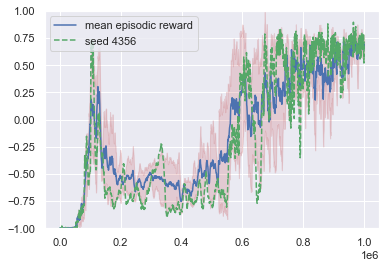

In [4]:
# experiment A dqn pixel observations (exp_001, algo_default)
plot_mean_std("IpWOBXoETom9jH0mosE2hQ", add_best=True, save_path="figures/dqn_pixel_exp_A")

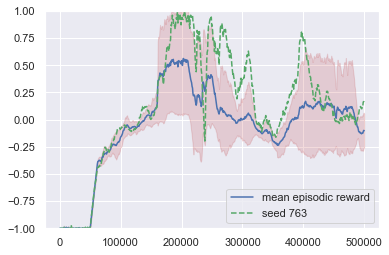

In [15]:
# experiment A low eps - tensor
plot_mean_std("2njnXgbgQOGaWp1v292s7w", add_best=True, legend='lower right', save_path="figures/dqn_low_eps")

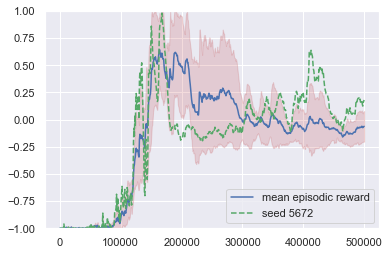

In [16]:
# experiment A low/long eps - tensor
plot_mean_std("KNTboySEQBKjTEnG7X8OKA", add_best=True, legend='lower right', save_path="figures/dqn_lolo_eps")

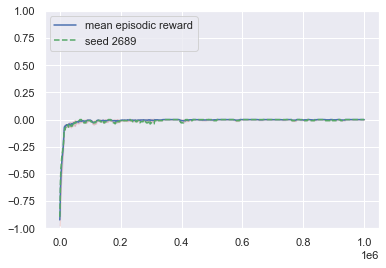

In [8]:
# experiment A a2c pixel observations (exp_001, algo_default)
plot_mean_std("SZaXYI5pRNSq8oLFYpoDWg", save_path="figures/a2c_pixel_exp_A", add_best=True)

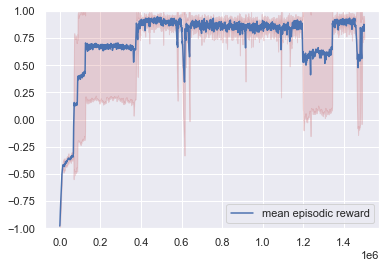

In [5]:
plot_mean_std("ceTRXZNyQ4yORbPvvBxaNg", legend="lower right", save_path="figures/a2c_pixel_entropy")

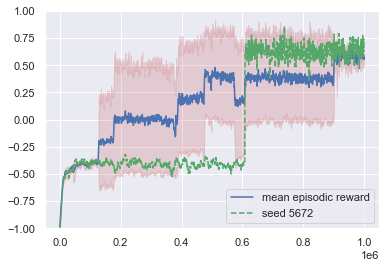

In [7]:
# A2C slip_1 entropy_6
plot_mean_std("2M2yBivFR5i22dmxK72y7g", legend="lower right", save_path="figures/a2c_pixel_slip_1", add_best=True)

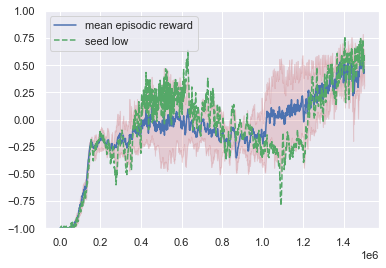

In [8]:
# dqn low eps slip3
plot_mean_std("aq7jZpJrTeePXBIOc4sD1Q", add_best=True, save_path="figures/dqn_low_eps_slip3")

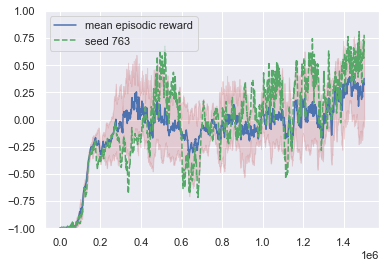

In [10]:
# dqn low eps slip2
plot_mean_std("mGquneJiQbmjZFxsy1zK0g", add_best=True, save_path="figures/dqn_low_eps_slip2")

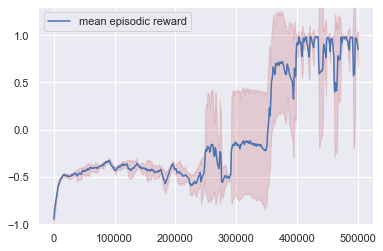

In [9]:
plot_mean_std("MKYbSkv8QMSxmQzGLyTAIg", save_path="figures/a2c_entropy_7", val_range=[-1, 1.3])

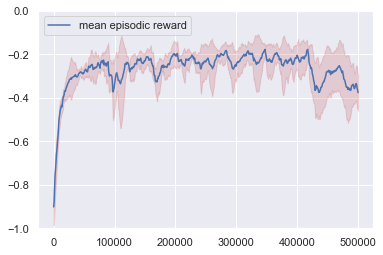

In [8]:
plot_mean_std("di4v05mEQXCEylP10hnf6w", save_path="figures/a2c_entropy_8", val_range=[-1, 0])